In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [20]:
data = pd.read_csv('/home/chudeo/project/Evidence_sentences.csv')
sentences = data['sentence'].tolist()
labels = [label.split(',') for label in data['word_labels']]

Preprocess the data:

In [21]:
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


In [22]:
# Find the maximum sequence length
max_len = max(len(seq) for seq in sequences)

# Pad the sequences
X = pad_sequences(sequences, maxlen=max_len, padding='post')

In [26]:
from keras.utils import to_categorical


# Convert labels to numerical values
unique_labels = set([label for labels_list in labels for label in labels_list])
label_to_id = {label: i for i, label in enumerate(unique_labels)}
y = [[label_to_id[label] for label in labels_list] for labels_list in labels]
y = pad_sequences(y, maxlen=max_len, padding='post')
y = [to_categorical(seq, num_classes=len(unique_labels)) for seq in y]


Build the Bidirectional LSTM model:


In [27]:
# Build the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model
model.fit(X, np.array(y), epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.9093 - loss: 0.2052 - val_accuracy: 0.9783 - val_loss: 0.0652
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.9810 - loss: 0.0571 - val_accuracy: 0.9786 - val_loss: 0.0651
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.9833 - loss: 0.0506 - val_accuracy: 0.9805 - val_loss: 0.0593
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9844 - loss: 0.0455 - val_accuracy: 0.9805 - val_loss: 0.0584
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9850 - loss: 0.0429 - val_accuracy: 0.9810 - val_loss: 0.0584
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9857 - loss: 0.0398 - val_accuracy: 0.9808 - val_loss: 0.0593
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.9867 - loss: 0.0372 - val_accuracy: 0.9810 - val_loss: 0.0589
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9870 - loss: 0.035

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(X, np.array(y))
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9890 - loss: 0.0293
Loss: 0.0360, Accuracy: 0.9875


In [30]:
def predict_entities(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
    predictions = model.predict(padded_sequence)
    predicted_labels = [[list(unique_labels)[np.argmax(label)] for label in prediction] for prediction in predictions[0]]
    return predicted_labels

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict labels for the data
predictions = model.predict(X)
predicted_labels = np.argmax(predictions, axis=-1)

132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


In [45]:
# Convert one-hot encoded labels to single labels
true_labels = np.argmax(np.array(y), axis=-1)

In [46]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.flatten(), predicted_labels.flatten())
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1116092     544    7035]
 [    398    2988    4291]
 [   2358     747   92985]]


In [47]:
# Generate classification report
report = classification_report(true_labels.flatten(), predicted_labels.flatten(), target_names=list(unique_labels))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           B       1.00      0.99      1.00   1123671
           I       0.70      0.39      0.50      7677
           O       0.89      0.97      0.93     96090

    accuracy                           0.99   1227438
   macro avg       0.86      0.78      0.81   1227438
weighted avg       0.99      0.99      0.99   1227438



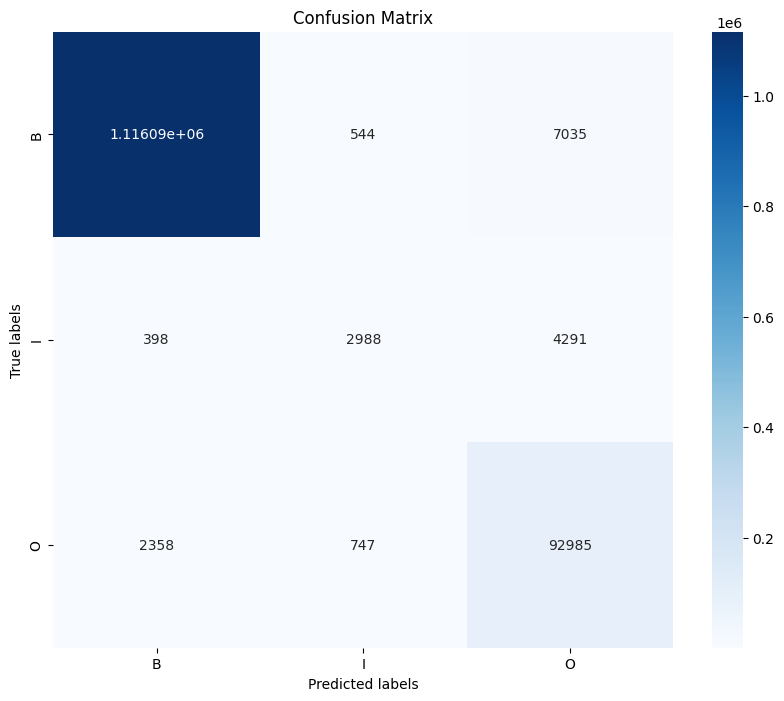

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=list(unique_labels), yticklabels=list(unique_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


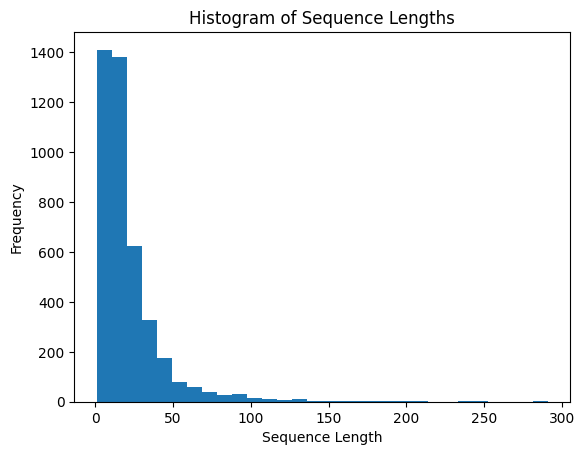

In [49]:
#Histogram of Sequence Lengths
plt.hist([len(seq) for seq in sequences], bins=30)
plt.title('Histogram of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


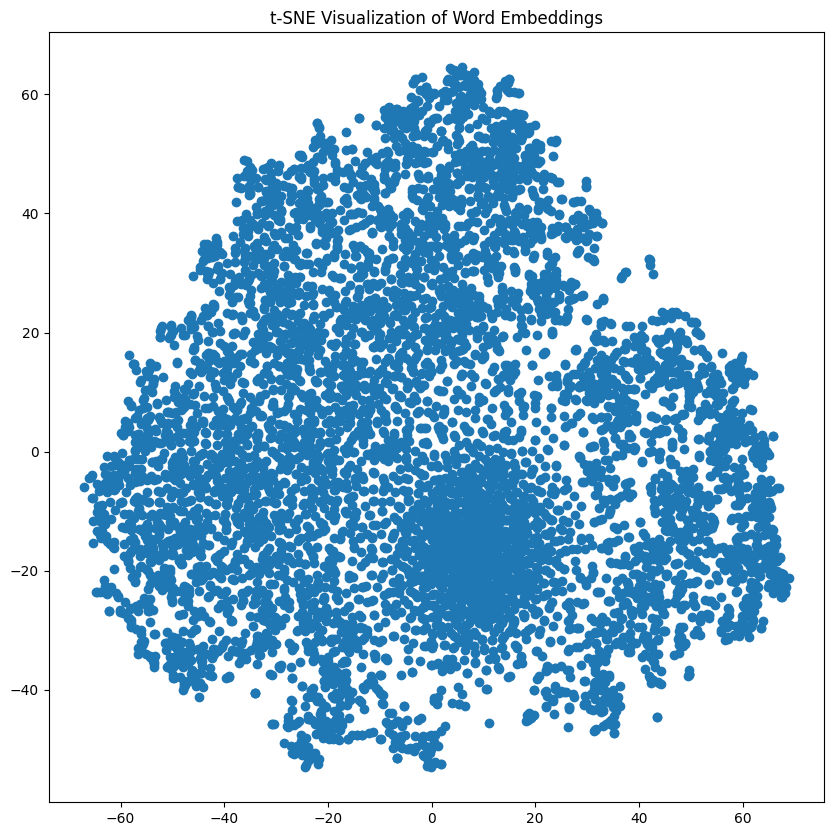

In [50]:
# If using pre-trained embeddings, you can visualize them using t-SNE or PCA
# For t-SNE
from sklearn.manifold import TSNE

# Assuming your embeddings are in model.layers[0].get_weights()[0]
embeddings = model.layers[0].get_weights()[0]

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9887 - loss: 0.0302 - val_accuracy: 0.9801 - val_loss: 0.0662
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9896 - loss: 0.0273 - val_accuracy: 0.9794 - val_loss: 0.0662
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9899 - loss: 0.0265 - val_accuracy: 0.9808 - val_loss: 0.0699
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9904 - loss: 0.0251 - val_accuracy: 0.9802 - val_loss: 0.0703
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9905 - loss: 0.0244 - val_accuracy: 0.9803 - val_loss: 0.0729
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9909 - loss: 0.0235 - val_accuracy: 0.9801 - val_loss: 0.0772
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9909 - loss: 0.0237 - val_accuracy: 0.9797 - val_loss: 0.0771
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9916 - loss: 0.0217 - 

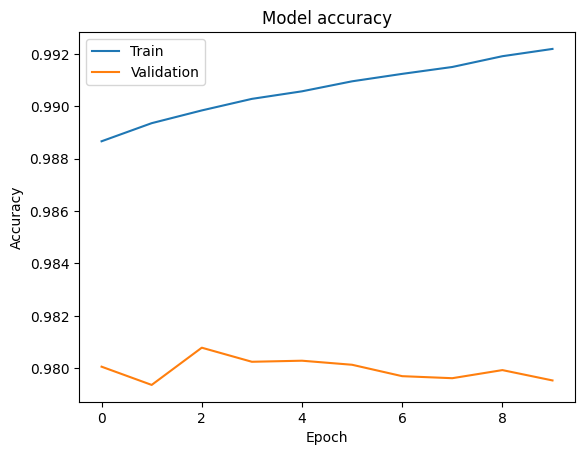

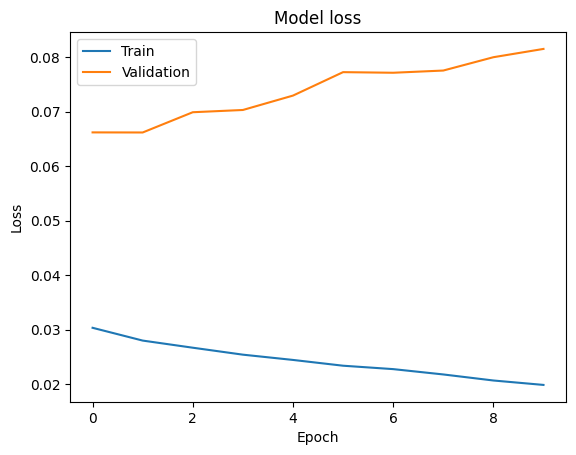

In [51]:
# Train the model
history = model.fit(X, np.array(y), epochs=10, batch_size=32, validation_split=0.2)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
